In [1]:
import os, sys, numpy as np, time, random, warnings
import matplotlib.pyplot as plt

# Set up the source path (adjust as needed for your project)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import your custom functions (ensure these are accessible in your PYTHONPATH)
# Import your custom functions (including the markovian solvers)
from optimal_code.utils import *
from optimal_code.optimal_solver import *
from optimal_code.optimal_solver_markov import *
from trees.build_trees_from_paths import *
# Import modules
from trees.multi_dimension.Multidimension_trees import *
from trees.multi_dimension.Multidimension_solver import *
from trees.multi_dimension.Multidimension_adapted_empirical_measure import *
from adapted_empirical_measure.AEM_grid import *
from benchmark_value_gaussian.Comp_AWD2_Gaussian import *
from adapted_empirical_measure.AEM_grid import *
from trees.tree_Node import *
from trees.treeAnalysis import *
from trees.treeVisualization import *
from trees.tree_AWD_utilities import *
from trees.build_trees_from_paths import build_tree_from_paths
from trees.awd_trees.Discrete_OT_Solver_algo import *
from trees.awd_trees.Nested_Dist_Algo import *

from optimal_code.utils_multidim import *
from optimal_code.optimal_solver_multidim import *

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)



In [2]:
sample_sizes = [4000, 6000, 10000, 15000, 20000, 25000, 35000, 50000, 75000]
fixed_grid = 0.4
n_runs = 10

# Define matrices (dimension 4)
L = np.array([[1, 0, 0, 0],
              [1, 2, 0, 0],
              [1, 2, 3, 0],
              [1, 2, 3, 4]])
M = np.array([[1, 0, 0, 0],
              [2, 1, 0, 0],
              [3, 2, 1, 0],
              [4, 3, 2, 1]])


# Parameters
d = 2
T = 2
dim = d * T

a, b = np.zeros(dim), np.zeros(dim)

## I need to put the kmeans stuff here

In [3]:
results = {}  # Dictionary to store results keyed by sample size

for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    
    for run in range(n_runs):
        # Generate two different random seeds (one for each matrix)
        seed1 = np.random.randint(10000)
        
        # Generate sample paths:
        # Process X (using matrix L) with seed1
        X, A = Lmatrix2paths_flat(L, n_sample, d, T, seed=seed1, verbose=False)
        Y, B = Lmatrix2paths_flat(M, n_sample, d, T, seed=seed1, verbose=False)
        
        # Compute the theoretical benchmark distance
        benchmark = adapted_wasserstein_squared_multidim(a, A, b, B, d, T)
        
        # Convert paths to adapted versions using the fixed grid
        adaptedX = path2adaptedpath_multidim(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath_multidim(Y, delta_n=fixed_grid)
        
        # Build quantization mapping:
        # Reshape the data so that we obtain a list of all ℝ² points:
        # adaptedX: shape (T+1, n_sample, d) -> (n_sample, T+1, d)
        points_X = adaptedX.transpose(1,0,2).reshape(-1, d)
        points_Y = adaptedY.transpose(1,0,2).reshape(-1, d)
        # Use np.unique along axis=0 to get unique grid points in ℝ².
        q2v = np.unique(np.concatenate([points_X, points_Y], axis=0), axis=0)
        # Convert each unique row (a 2D vector) to a tuple so it can be used as a key.
        q2v_list = [tuple(row) for row in q2v]
        v2q = {val: i for i, val in enumerate(q2v_list)}
        
        # Quantize each path: iterate over sample paths.
        # Resulting qX will have shape (n_sample, T+1) with integer entries.
        qX = np.array([[v2q[tuple(x)] for x in sample] 
                        for sample in adaptedX.transpose(1,0,2)])
        qY = np.array([[v2q[tuple(x)] for x in sample] 
                        for sample in adaptedY.transpose(1,0,2)])
        
        # Sort the quantized paths lexicographically (as in your 1D code)
        qX = sort_qpath_multidim(qX.T)
        qY = sort_qpath_multidim(qY.T)
        
        # Build conditional distributions from the quantized paths.
        mu_x = qpath2mu_x_multidim(qX)
        nu_y = qpath2mu_x_multidim(qY)
        mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn = list_repr_mu_x_multidim(mu_x, q2v)
        nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn = list_repr_mu_x_multidim(nu_y, q2v)
        
        # Compute the numerical adapted Wasserstein squared distance.
        t_start = time.perf_counter()
        AW_2square = nested2_parallel_multidim(mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn,
                                        nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn,
                                        n_processes=42, power=2)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Sample size {n_sample}, Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")
    
    # Store the results for the current sample size
    results[n_sample] = {"distances": distances_runs,
                         "times": times_runs,
                         "benchmark": benchmark}


Running experiments for sample size: 4000


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 90.35it/s]


Sample size 4000, Run 1: AW_2^2 = 21.5687, Time = 0.6997 s


100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 179.41it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 184.29it/s]

 62%|████████████████████████████▏                | 5/8 [00:00<00:00, 45.21it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 81.13it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 102.63it/s]


Sample size 4000, Run 2: AW_2^2 = 22.9108, Time = 0.5880 s


100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 151.90it/s]

 75%|█████████████████████████████████▊           | 6/8 [00:00<00:00, 58.94it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 65.26it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 105.60it/s]


Sample size 4000, Run 3: AW_2^2 = 21.7906, Time = 0.5614 s


  0%|                                                     | 0/8 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 142.97it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 68.21it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 64.56it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 92.29it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 95.78it/s]


Sample size 4000, Run 4: AW_2^2 = 20.7005, Time = 0.5686 s


  0%|                                                     | 0/9 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 144.40it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 136.81it/s]

  0%|                                                     | 0/9 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 83.61it/s]

 56%|█████████████████████████                    | 5/9 [00:00<00:00, 39.67it/s]

 67%|██████████████████████████████               | 6/9 [00:00<00:00, 56.60it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 127.17it/s]



100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 75.11it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 73.96it/s]



100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 39.92it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 83.12it/s]


Sample size 4000, Run 5: AW_2^2 = 22.2400, Time = 0.6156 s


100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 123.34it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 119.50it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 74.73it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 99.68it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 106.70it/s]


Sample size 4000, Run 6: AW_2^2 = 21.2221, Time = 0.5573 s


100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 175.08it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 165.67it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 75.43it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 144.70it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 98.47it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 104.48it/s]


Sample size 4000, Run 7: AW_2^2 = 22.3996, Time = 0.5779 s


  0%|                                                     | 0/8 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 113.12it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 103.82it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 87.54it/s]

  0%|                                                     | 0/9 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 103.43it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 73.40it/s]


Sample size 4000, Run 8: AW_2^2 = 21.4813, Time = 0.6251 s


100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 192.01it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 179.11it/s]


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 80.34it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 49.57it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 93.44it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 104.41it/s]


Sample size 4000, Run 9: AW_2^2 = 22.2842, Time = 0.6106 s


100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 198.96it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 124.28it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 103.57it/s]


Sample size 4000, Run 10: AW_2^2 = 21.9100, Time = 0.5908 s

Running experiments for sample size: 6000


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 151.30it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 48.85it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 97.61it/s]



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.06it/s]


Sample size 6000, Run 1: AW_2^2 = 21.8988, Time = 0.7835 s


100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 138.27it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 74.67it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 45.00it/s]


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 44.85it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 98.36it/s]


Sample size 6000, Run 2: AW_2^2 = 21.6215, Time = 0.7502 s


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 90.71it/s]

  0%|                                                     | 0/9 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 55.87it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 58.81it/s]


Sample size 6000, Run 3: AW_2^2 = 22.3513, Time = 0.8081 s


 70%|██████████████████████████████▊             | 7/10 [00:00<00:00, 69.31it/s]

 89%|████████████████████████████████████████     | 8/9 [00:00<00:00, 72.29it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 63.71it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 37.22it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 91.60it/s]


Sample size 6000, Run 4: AW_2^2 = 21.4909, Time = 0.7972 s


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 72.96it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 55.28it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 24.60it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 89.80it/s]


Sample size 6000, Run 5: AW_2^2 = 21.8382, Time = 0.7605 s


 60%|██████████████████████████▍                 | 6/10 [00:00<00:00, 51.59it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 155.95it/s]


 30%|█████████████▏                              | 3/10 [00:00<00:00, 25.89it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 78.39it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 91.26it/s]


Sample size 6000, Run 6: AW_2^2 = 21.6415, Time = 0.7730 s


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 69.58it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 59.65it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 30.51it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 94.93it/s]


Sample size 6000, Run 7: AW_2^2 = 21.7937, Time = 0.8022 s


  0%|                                                     | 0/9 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 85.70it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 55.33it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 61.04it/s]


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 62.86it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 28.09it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 91.12it/s]


Sample size 6000, Run 8: AW_2^2 = 22.9906, Time = 0.8421 s


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 79.25it/s]


 22%|██████████                                   | 2/9 [00:00<00:00, 18.13it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 60.84it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 55.26it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 53.10it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 89.27it/s]


Sample size 6000, Run 9: AW_2^2 = 21.8329, Time = 0.8848 s


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 135.36it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 70.31it/s]

 44%|████████████████████                         | 4/9 [00:00<00:00, 39.75it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 68.41it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 54.09it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 93.60it/s]


Sample size 6000, Run 10: AW_2^2 = 21.8072, Time = 0.8492 s

Running experiments for sample size: 10000


 30%|█████████████▏                              | 3/10 [00:00<00:00, 27.15it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 88.62it/s]

 40%|█████████████████▌                          | 4/10 [00:00<00:00, 31.33it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 50.49it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 17.90it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 76.26it/s]


Sample size 10000, Run 1: AW_2^2 = 21.6458, Time = 1.3816 s


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 126.11it/s]

 30%|█████████████▏                              | 3/10 [00:00<00:00, 28.70it/s]

 18%|████████                                    | 2/11 [00:00<00:00, 13.74it/s]

 30%|█████████████▏                              | 3/10 [00:00<00:00, 25.17it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 56.56it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 72.28it/s]


Sample size 10000, Run 2: AW_2^2 = 22.4807, Time = 1.5322 s


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 72.54it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 35.08it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 76.86it/s]


Sample size 10000, Run 3: AW_2^2 = 22.1749, Time = 1.4687 s


 30%|█████████████▏                              | 3/10 [00:00<00:00, 29.82it/s]


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 51.35it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 55.69it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 44.35it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 45.23it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 79.46it/s]


Sample size 10000, Run 4: AW_2^2 = 22.5783, Time = 1.3400 s


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 89.48it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 115.83it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 79.25it/s]


Sample size 10000, Run 5: AW_2^2 = 21.8313, Time = 1.3290 s


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 174.17it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 374.28it/s]


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 113.81it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 77.29it/s]


Sample size 10000, Run 6: AW_2^2 = 22.2828, Time = 1.2593 s


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 89.03it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 75.52it/s]


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 62.67it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 49.25it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 16.24it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 52.55it/s]


Sample size 10000, Run 7: AW_2^2 = 22.6729, Time = 1.4446 s


 80%|███████████████████████████████████▏        | 8/10 [00:00<00:00, 68.91it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 89.89it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 80.45it/s]



100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 111.40it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 48.97it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 36.10it/s]

 90%|███████████████████████████████████████▌    | 9/10 [00:00<00:00, 15.48it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 75.35it/s]


Sample size 10000, Run 8: AW_2^2 = 22.6621, Time = 1.3544 s


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 223.03it/s]

 20%|████████▊                                   | 2/10 [00:00<00:00, 13.07it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 80.30it/s]


Sample size 10000, Run 9: AW_2^2 = 22.0864, Time = 1.4171 s


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 96.17it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 92.66it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 76.19it/s]


Sample size 10000, Run 10: AW_2^2 = 22.1867, Time = 1.2914 s

Running experiments for sample size: 15000


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 91.66it/s]

 18%|████████                                    | 2/11 [00:00<00:00,  9.34it/s]

100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 117.79it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 56.68it/s]

 91%|███████████████████████████████████████    | 10/11 [00:00<00:00, 46.35it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 45.27it/s]


Sample size 15000, Run 1: AW_2^2 = 22.1429, Time = 1.7948 s


 55%|████████████████████████                    | 6/11 [00:00<00:00, 56.95it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 56.34it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 38.87it/s]

 18%|████████                                    | 2/11 [00:00<00:01,  5.59it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 60.98it/s]


Sample size 15000, Run 2: AW_2^2 = 22.3203, Time = 2.1127 s


 91%|███████████████████████████████████████    | 10/11 [00:00<00:00, 96.67it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 51.46it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 64.24it/s]


Sample size 15000, Run 3: AW_2^2 = 22.1699, Time = 2.1482 s


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 65.22it/s]

 27%|████████████                                | 3/11 [00:00<00:00, 25.94it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 42.21it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 64.06it/s]


Sample size 15000, Run 4: AW_2^2 = 22.1898, Time = 2.2648 s


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 115.16it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 57.93it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 44.63it/s]


Sample size 15000, Run 5: AW_2^2 = 22.0528, Time = 2.1199 s


 27%|████████████                                | 3/11 [00:00<00:00, 24.24it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 40.52it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 62.82it/s]


Sample size 15000, Run 6: AW_2^2 = 22.2445, Time = 1.8023 s


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 129.34it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 67.84it/s]


Sample size 15000, Run 7: AW_2^2 = 22.1733, Time = 2.1393 s


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 75.70it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 58.49it/s]


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 77.22it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 73.48it/s]


Sample size 15000, Run 8: AW_2^2 = 22.2606, Time = 1.8860 s


 82%|████████████████████████████████████        | 9/11 [00:00<00:00, 86.90it/s]


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 68.92it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 53.10it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 39.85it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 24.91it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 66.30it/s]


Sample size 15000, Run 9: AW_2^2 = 22.3858, Time = 2.2131 s


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 63.84it/s]




100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 82.21it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 64.25it/s]


Sample size 15000, Run 10: AW_2^2 = 22.4017, Time = 2.1898 s

Running experiments for sample size: 20000


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 30.08it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 59.81it/s]


Sample size 20000, Run 1: AW_2^2 = 22.1742, Time = 3.0714 s


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 36.84it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 19.65it/s]

100%|███████████████████████████████████████████| 12/12 [00:01<00:00, 10.53it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 57.05it/s]


Sample size 20000, Run 2: AW_2^2 = 22.3288, Time = 3.2194 s


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 67.79it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 67.16it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 15.68it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 58.93it/s]


Sample size 20000, Run 3: AW_2^2 = 22.0046, Time = 3.0586 s


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 97.05it/s]

100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 143.49it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 48.09it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 61.69it/s]


Sample size 20000, Run 4: AW_2^2 = 21.9175, Time = 3.1028 s


 27%|████████████                                | 3/11 [00:00<00:00, 25.25it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 57.90it/s]


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 45.06it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 57.47it/s]


Sample size 20000, Run 5: AW_2^2 = 22.1066, Time = 3.0707 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 55.89it/s]


Sample size 20000, Run 6: AW_2^2 = 22.3661, Time = 2.7520 s


 64%|████████████████████████████                | 7/11 [00:00<00:00, 58.61it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 43.72it/s]



 33%|██████████████▋                             | 4/12 [00:00<00:00, 13.60it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 59.13it/s]


Sample size 20000, Run 7: AW_2^2 = 22.1416, Time = 2.9268 s


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 71.90it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 56.93it/s]


Sample size 20000, Run 8: AW_2^2 = 22.3522, Time = 2.9895 s


 33%|██████████████▋                             | 4/12 [00:00<00:00, 15.62it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 60.80it/s]


Sample size 20000, Run 9: AW_2^2 = 22.0241, Time = 2.9359 s


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 62.35it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 39.08it/s]

 33%|██████████████▋                             | 4/12 [00:00<00:00,  8.80it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 60.67it/s]


Sample size 20000, Run 10: AW_2^2 = 21.8876, Time = 2.8398 s

Running experiments for sample size: 25000


  9%|████                                        | 1/11 [00:00<00:01,  7.64it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 60.78it/s]


Sample size 25000, Run 1: AW_2^2 = 21.9457, Time = 3.6273 s


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 63.70it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 57.44it/s]


Sample size 25000, Run 2: AW_2^2 = 22.1943, Time = 4.1984 s


 17%|███████▎                                    | 2/12 [00:00<00:00, 18.09it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 46.47it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 56.93it/s]


Sample size 25000, Run 3: AW_2^2 = 22.0901, Time = 3.6821 s


  8%|███▋                                        | 1/12 [00:00<00:03,  3.51it/s]

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 27.16it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 55.59it/s]


Sample size 25000, Run 4: AW_2^2 = 22.4452, Time = 3.4934 s


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 60.71it/s]


  8%|███▋                                        | 1/12 [00:00<00:03,  3.10it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 53.82it/s]


Sample size 25000, Run 5: AW_2^2 = 22.2393, Time = 3.8906 s


 36%|████████████████                            | 4/11 [00:00<00:00, 34.02it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 69.35it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 51.71it/s]

 67%|█████████████████████████████▎              | 8/12 [00:00<00:00, 19.42it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 30.89it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 57.00it/s]


Sample size 25000, Run 6: AW_2^2 = 22.1763, Time = 3.9421 s


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 64.59it/s]

 17%|███████▎                                    | 2/12 [00:00<00:01,  8.26it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 56.35it/s]


Sample size 25000, Run 7: AW_2^2 = 22.3089, Time = 4.2176 s


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 50.91it/s]

 17%|███████▎                                    | 2/12 [00:00<00:01,  7.59it/s]

 25%|███████████                                 | 3/12 [00:00<00:01,  7.53it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 18.92it/s]

 75%|█████████████████████████████████           | 9/12 [00:00<00:00, 14.67it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 13.09it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 60.10it/s]


Sample size 25000, Run 8: AW_2^2 = 21.9771, Time = 4.3563 s


 73%|████████████████████████████████            | 8/11 [00:00<00:00, 70.94it/s]

 18%|████████                                    | 2/11 [00:00<00:00, 13.37it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 61.75it/s]


Sample size 25000, Run 9: AW_2^2 = 22.2494, Time = 3.5803 s


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 89.15it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 59.00it/s]


Sample size 25000, Run 10: AW_2^2 = 22.5111, Time = 4.1962 s

Running experiments for sample size: 35000


 42%|██████████████████▎                         | 5/12 [00:00<00:00, 25.28it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 56.65it/s]

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 36.06it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 15.30it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 55.76it/s]


Sample size 35000, Run 1: AW_2^2 = 22.1732, Time = 6.3076 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 52.90it/s]


Sample size 35000, Run 2: AW_2^2 = 22.0070, Time = 5.9469 s


 17%|███████▎                                    | 2/12 [00:00<00:00, 10.40it/s]

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 61.81it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 51.40it/s]


Sample size 35000, Run 3: AW_2^2 = 22.2968, Time = 6.8564 s


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 96.89it/s]

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 16.04it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 56.00it/s]


Sample size 35000, Run 4: AW_2^2 = 22.0458, Time = 6.6299 s


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 46.70it/s]

 58%|█████████████████████████▋                  | 7/12 [00:00<00:00, 34.26it/s]

 31%|█████████████▌                              | 4/13 [00:00<00:00, 10.09it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 53.88it/s]


Sample size 35000, Run 5: AW_2^2 = 22.0321, Time = 7.0485 s


 15%|██████▊                                     | 2/13 [00:00<00:01, 10.13it/s]

 85%|████████████████████████████████████▍      | 11/13 [00:00<00:00, 20.33it/s]

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 23.05it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 54.12it/s]


Sample size 35000, Run 6: AW_2^2 = 22.0089, Time = 6.3536 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 50.78it/s]


Sample size 35000, Run 7: AW_2^2 = 22.0150, Time = 6.6260 s


 15%|██████▊                                     | 2/13 [00:00<00:00, 11.51it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 49.24it/s]


Sample size 35000, Run 8: AW_2^2 = 21.9166, Time = 6.7097 s


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 24.05it/s]

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 21.64it/s]

100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  8.62it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 52.50it/s]


Sample size 35000, Run 9: AW_2^2 = 22.0265, Time = 5.9917 s


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 38.61it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 53.60it/s]


Sample size 35000, Run 10: AW_2^2 = 22.1241, Time = 6.2180 s

Running experiments for sample size: 50000


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 44.73it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 47.73it/s]


Sample size 50000, Run 1: AW_2^2 = 22.2834, Time = 10.1833 s


 69%|██████████████████████████████▍             | 9/13 [00:00<00:00, 27.81it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 48.87it/s]


Sample size 50000, Run 2: AW_2^2 = 21.8375, Time = 10.2216 s


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 73.75it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 48.77it/s]


Sample size 50000, Run 3: AW_2^2 = 21.9667, Time = 10.2754 s


 31%|█████████████▌                              | 4/13 [00:00<00:00, 36.18it/s]

100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 33.96it/s]

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 30.24it/s]

 21%|█████████▍                                  | 3/14 [00:00<00:03,  3.32it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 47.56it/s]


Sample size 50000, Run 4: AW_2^2 = 21.9172, Time = 10.6160 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 50.20it/s]


Sample size 50000, Run 5: AW_2^2 = 21.9756, Time = 8.8537 s


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 44.49it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 50.10it/s]


Sample size 50000, Run 6: AW_2^2 = 21.8145, Time = 8.8206 s


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 55.39it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 49.03it/s]


Sample size 50000, Run 7: AW_2^2 = 21.9406, Time = 11.2959 s


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 52.15it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 47.70it/s]


Sample size 50000, Run 8: AW_2^2 = 21.8035, Time = 10.1909 s


  8%|███▍                                        | 1/13 [00:00<00:02,  4.11it/s]

 79%|█████████████████████████████████▊         | 11/14 [00:00<00:00, 38.20it/s]

 57%|█████████████████████████▏                  | 8/14 [00:00<00:00, 13.80it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 49.75it/s]


Sample size 50000, Run 9: AW_2^2 = 22.0608, Time = 10.8850 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 51.23it/s]


Sample size 50000, Run 10: AW_2^2 = 22.1417, Time = 11.2869 s

Running experiments for sample size: 75000


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 28.73it/s]

100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  9.33it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 45.79it/s]


Sample size 75000, Run 1: AW_2^2 = 21.9750, Time = 17.4383 s


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 47.61it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 41.96it/s]


Sample size 75000, Run 2: AW_2^2 = 21.9655, Time = 18.5294 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 40.85it/s]


Sample size 75000, Run 3: AW_2^2 = 21.8994, Time = 19.2188 s


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 45.92it/s]

100%|███████████████████████████████████████████| 14/14 [00:02<00:00,  5.42it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 46.24it/s]


Sample size 75000, Run 4: AW_2^2 = 21.9542, Time = 18.0268 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 43.90it/s]


Sample size 75000, Run 5: AW_2^2 = 21.9758, Time = 18.1696 s


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.37it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 37.73it/s]


Sample size 75000, Run 6: AW_2^2 = 22.0768, Time = 17.9271 s


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 74.17it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 41.57it/s]


Sample size 75000, Run 7: AW_2^2 = 22.1754, Time = 18.0116 s


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 25.53it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 41.18it/s]


Sample size 75000, Run 8: AW_2^2 = 21.9397, Time = 18.1840 s


100%|███████████████████████████████████████████| 14/14 [00:01<00:00, 11.25it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.23it/s]


Sample size 75000, Run 9: AW_2^2 = 21.9862, Time = 17.0268 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 43.33it/s]


Sample size 75000, Run 10: AW_2^2 = 21.7792, Time = 17.8596 s


In [4]:
print("\nAggregated Results:")
aggregated = {}
for n_sample in sorted(results.keys()):
    data = results[n_sample]
    dists = data["distances"]
    times = data["times"]
    bench = data["benchmark"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    abs_errors = np.abs(dists - bench)
    mean_abs_err = np.mean(abs_errors)
    std_abs_err = np.std(abs_errors)
    aggregated[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time,
        "mean_abs_error": mean_abs_err,
        "std_abs_error": std_abs_err,
        "benchmark": bench
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f} s ± {std_time:.4f} s")
    print(f"  Mean Absolute Error: {mean_abs_err:.4f} ± {std_abs_err:.4f}")
    print(f"  Benchmark: {bench:.4f}\n")


Aggregated Results:
Sample Size: 4000
  Mean AW_2^2: 21.8508 ± 0.6088
  Mean Time: 0.5995 s ± 0.0399 s
  Mean Absolute Error: 0.5208 ± 0.3593
  Benchmark: 22.0234

Sample Size: 6000
  Mean AW_2^2: 21.9266 ± 0.4155
  Mean Time: 0.8051 s ± 0.0403 s
  Mean Absolute Error: 0.3558 ± 0.2354
  Benchmark: 22.0234

Sample Size: 10000
  Mean AW_2^2: 22.2602 ± 0.3296
  Mean Time: 1.3818 s ± 0.0799 s
  Mean Absolute Error: 0.3508 ± 0.2042
  Benchmark: 22.0234

Sample Size: 15000
  Mean AW_2^2: 22.2341 ± 0.1050
  Mean Time: 2.0671 s ± 0.1641 s
  Mean Absolute Error: 0.2108 ± 0.1050
  Benchmark: 22.0234

Sample Size: 20000
  Mean AW_2^2: 22.1303 ± 0.1668
  Mean Time: 2.9967 s ± 0.1299 s
  Mean Absolute Error: 0.1590 ± 0.1181
  Benchmark: 22.0234

Sample Size: 25000
  Mean AW_2^2: 22.2138 ± 0.1726
  Mean Time: 3.9184 s ± 0.2956 s
  Mean Absolute Error: 0.2152 ± 0.1405
  Benchmark: 22.0234

Sample Size: 35000
  Mean AW_2^2: 22.0646 ± 0.1014
  Mean Time: 6.4688 s ± 0.3460 s
  Mean Absolute Error: 0.07

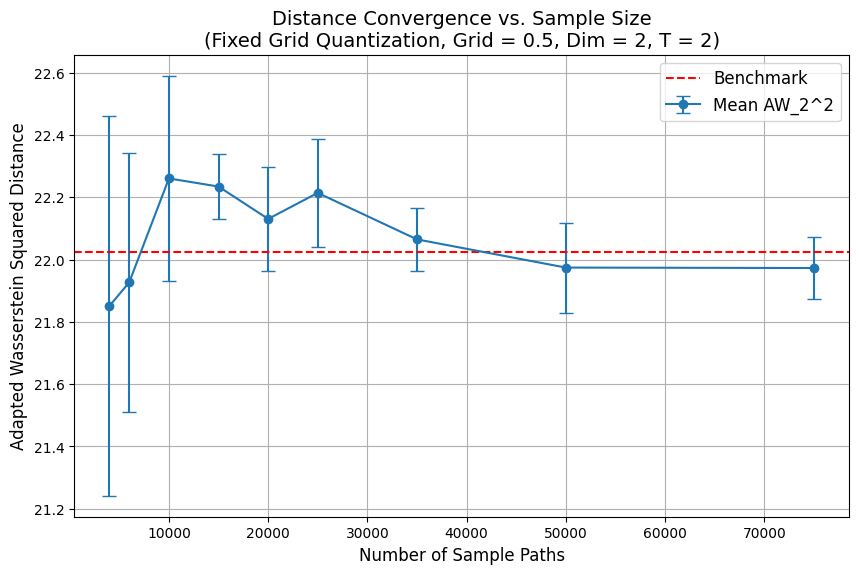

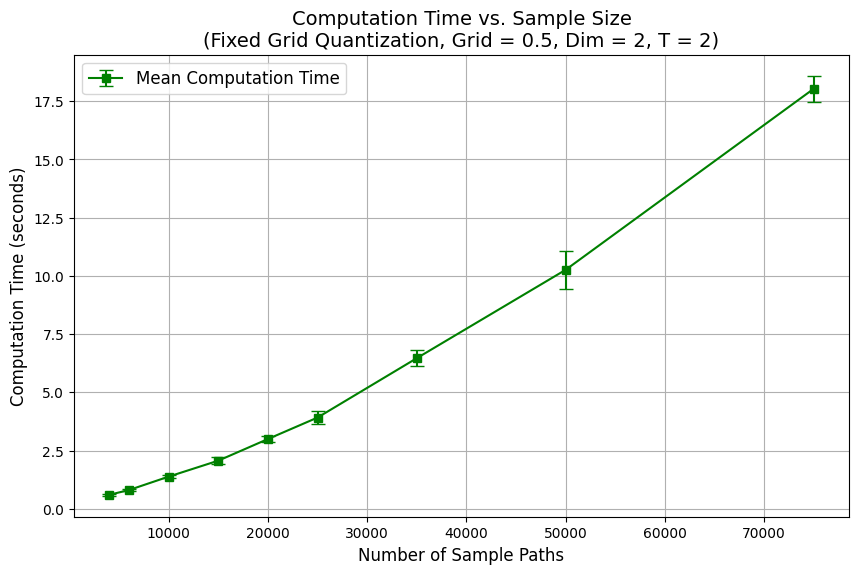

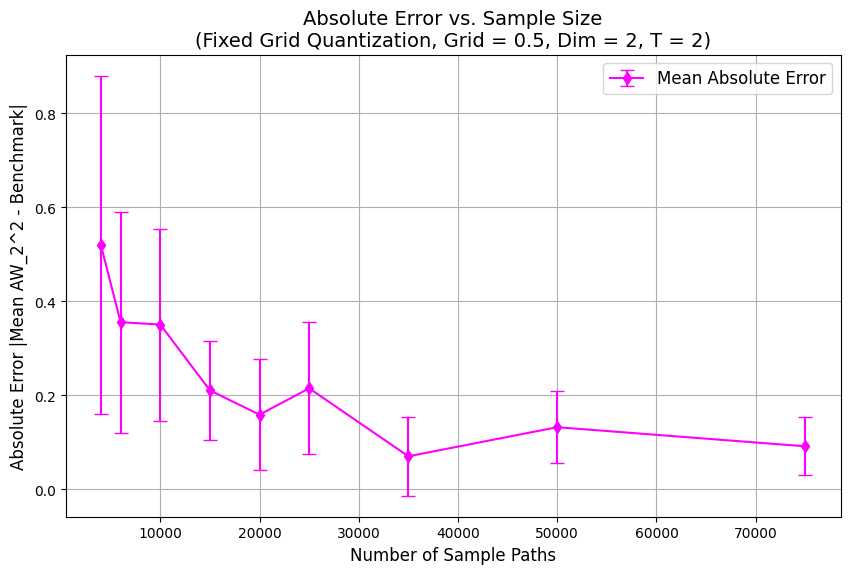

In [5]:
sample_list = sorted(aggregated.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in sample_list]
std_distances = [aggregated[n]["std_distance"] for n in sample_list]
mean_times = [aggregated[n]["mean_time"] for n in sample_list]
std_times = [aggregated[n]["std_time"] for n in sample_list]
mean_abs_errors = [aggregated[n]["mean_abs_error"] for n in sample_list]
std_abs_errors = [aggregated[n]["std_abs_error"] for n in sample_list]
benchmark = aggregated[sample_list[0]]["benchmark"]  # assuming benchmark is the same across sizes

# Plot 1: Distance Convergence
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.axhline(y=benchmark, color="red", linestyle="--", label="Benchmark")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(Fixed Grid Quantization, Grid = 0.5, Dim = 2, T = 2)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(Fixed Grid Quantization, Grid = 0.5, Dim = 2, T = 2)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 3: Absolute Error
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_abs_errors, yerr=std_abs_errors, fmt="d-", capsize=5, color="magenta", label="Mean Absolute Error")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Absolute Error |Mean AW_2^2 - Benchmark|", fontsize=12)
plt.title("Absolute Error vs. Sample Size\n(Fixed Grid Quantization, Grid = 0.5, Dim = 2, T = 2)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
results_kmeans = {}  # Dictionary to store results keyed by sample size

n_runs = 10

sample_sizes = [200, 400, 600, 800, 1000]

for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    
    for run in range(n_runs):
        # Generate two different random seeds (one for each matrix)
        seed1 = np.random.randint(10000)
        
        # Generate sample paths:
        # Process X (using matrix L) with seed1
        X, A = Lmatrix2paths_flat(L, n_sample, d, T, seed=seed1, verbose=False)
        Y, B = Lmatrix2paths_flat(M, n_sample, d, T, seed=seed1, verbose=False)      
        # Compute the theoretical benchmark distance
        benchmark = adapted_wasserstein_squared_multidim(a, A, b, B, d, T)
        
        t_start = time.perf_counter()
        adaptedX = multidim_empirical_k_means_measure_new(X, delta_n=fixed_grid, k_start = 50)
        adaptedY = multidim_empirical_k_means_measure_new(Y, delta_n=fixed_grid, k_start = 10)
        print(time.perf_counter() - t_start)
        # Build quantization mapping:
        # Reshape the data so that we obtain a list of all ℝ² points:
        # adaptedX: shape (T+1, n_sample, d) -> (n_sample, T+1, d)
        points_X = adaptedX.transpose(1,0,2).reshape(-1, d)
        points_Y = adaptedY.transpose(1,0,2).reshape(-1, d)
        # Use np.unique along axis=0 to get unique grid points in ℝ².
        q2v = np.unique(np.concatenate([points_X, points_Y], axis=0), axis=0)
        # Convert each unique row (a 2D vector) to a tuple so it can be used as a key.
        q2v_list = [tuple(row) for row in q2v]
        v2q = {val: i for i, val in enumerate(q2v_list)}
        
        # Quantize each path: iterate over sample paths.
        # Resulting qX will have shape (n_sample, T+1) with integer entries.
        qX = np.array([[v2q[tuple(x)] for x in sample] 
                        for sample in adaptedX.transpose(1,0,2)])
        qY = np.array([[v2q[tuple(x)] for x in sample] 
                        for sample in adaptedY.transpose(1,0,2)])
        
        # Sort the quantized paths lexicographically (as in your 1D code)
        qX = sort_qpath_multidim(qX.T)
        qY = sort_qpath_multidim(qY.T)
        
        # Build conditional distributions from the quantized paths.
        mu_x = qpath2mu_x_multidim(qX)
        nu_y = qpath2mu_x_multidim(qY)


        mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn = list_repr_mu_x_multidim(mu_x, q2v)
        nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn = list_repr_mu_x_multidim(nu_y, q2v)
        
        # Compute the numerical adapted Wasserstein squared distance.
        t_start = time.perf_counter()
        AW_2square = nested2_parallel_multidim(mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn,
                                        nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn,
                                        n_processes=42, power=2)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Sample size {n_sample}, Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")
    
    # Store the results for the current sample size
    results_kmeans[n_sample] = {"distances": distances_runs,
                         "times": times_runs,
                         "benchmark": benchmark}



Running experiments for sample size: 200
5.546322709065862


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 604.67it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 421.86it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 405.99it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 382.95it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 177.78it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 393.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1478.43it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 333.17it/s]




100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 513.82it/s]


Sample size 200, Run 1: AW_2^2 = 20.9782, Time = 0.4463 s
3.385310609010048


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 563.15it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 563.22it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 401.33it/s]
















100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 338.50it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 597.78it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 627.37it/s]



100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 704.93it/s]


Sample size 200, Run 2: AW_2^2 = 18.7503, Time = 0.3673 s
3.2307220139773563


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 175.94it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1823.61it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1834.78it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 409.78it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 180.57it/s]



100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 393.41it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 595.44it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 406.11it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 275.33it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 689.06it/s]


Sample size 200, Run 3: AW_2^2 = 20.8699, Time = 0.3980 s
1.5622423430904746


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 417.16it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1908.67it/s]


  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1874.97it/s]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1360.90it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 387.86it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 704.93it/s]


Sample size 200, Run 4: AW_2^2 = 19.3767, Time = 0.3806 s
2.0373402549885213


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 389.19it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 383.83it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 379.99it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 303.91it/s]





100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 841.38it/s]


  0%|                                                     | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 438.23it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 376.71it/s]


Sample size 200, Run 5: AW_2^2 = 19.0941, Time = 0.3653 s
3.223434205981903


  0%|                                                     | 0/2 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 241.36it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 223.68it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 285.57it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 385.17it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 394.96it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 320.81it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 190.38it/s]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1457.87it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 727.67it/s]


Sample size 200, Run 6: AW_2^2 = 20.9217, Time = 0.3702 s
2.158436735975556


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 638.45it/s]


  0%|                                                     | 0/1 [00:00<?, ?it/s]




100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 367.24it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 370.78it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 370.39it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 160.64it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 796.49it/s]


Sample size 200, Run 7: AW_2^2 = 20.5908, Time = 0.4384 s
5.95039531996008


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 336.62it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 302.71it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 402.35it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 855.81it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1381.52it/s]



100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 705.16it/s]


Sample size 200, Run 8: AW_2^2 = 22.7852, Time = 0.3965 s
1.7906130680348724


  0%|                                                     | 0/2 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 559.24it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 549.86it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1750.54it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 367.76it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 383.29it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]



100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 375.14it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 373.86it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 352.26it/s]


Sample size 200, Run 9: AW_2^2 = 20.2829, Time = 0.3807 s
6.309895538026467


  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 613.07it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 413.95it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 604.28it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 361.48it/s]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1442.33it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 332.17it/s]




100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 175.00it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 135.14it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 760.25it/s]


Sample size 200, Run 10: AW_2^2 = 21.6755, Time = 0.4200 s

Running experiments for sample size: 400
26.933319776086137


  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 286.05it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 285.53it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 225.35it/s]




100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 248.30it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 276.34it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 143.92it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 539.25it/s]


Sample size 400, Run 1: AW_2^2 = 20.7575, Time = 0.3890 s
29.919004815048538


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 384.23it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 243.24it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 304.18it/s]



100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1474.53it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 449.98it/s]



100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 774.86it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 294.28it/s]


Sample size 400, Run 2: AW_2^2 = 18.8790, Time = 0.4149 s
27.37516929593403


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 323.35it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 325.31it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 353.50it/s]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1533.85it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 466.01it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 464.15it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 470.08it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 224.47it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 527.78it/s]


Sample size 400, Run 3: AW_2^2 = 21.8864, Time = 0.4014 s
29.79847027605865


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 282.00it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 170.74it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 250.73it/s]



100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 296.94it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 279.66it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 185.85it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 446.99it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 289.18it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 507.11it/s]


Sample size 400, Run 4: AW_2^2 = 22.2405, Time = 0.4138 s
27.76847520598676


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 421.81it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 302.73it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 454.20it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 283.96it/s]




100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 298.93it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 248.44it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 203.33it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 176.35it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 537.46it/s]


Sample size 400, Run 5: AW_2^2 = 22.9833, Time = 0.4411 s
29.237337319995277


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 290.16it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 197.78it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 280.25it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 282.01it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 268.17it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 266.36it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 264.98it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 262.73it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 511.25it/s]


Sample size 400, Run 6: AW_2^2 = 20.8732, Time = 0.3767 s
25.440173494047485


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 276.34it/s]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 237.37it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 404.91it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 417.26it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 285.76it/s]



100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 457.64it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 273.60it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 282.85it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 223.48it/s]


Sample size 400, Run 7: AW_2^2 = 22.1737, Time = 0.4012 s
27.555974148912355


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 660.24it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 282.74it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 385.44it/s]


  0%|                                                     | 0/2 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 375.00it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 287.08it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1110.19it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 267.76it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 477.33it/s]


Sample size 400, Run 8: AW_2^2 = 22.6033, Time = 0.4101 s
26.16757626400795


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 608.87it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 317.42it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 404.40it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 393.23it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 284.25it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 347.86it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 283.05it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1495.83it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 535.67it/s]


Sample size 400, Run 9: AW_2^2 = 18.9729, Time = 0.4088 s
29.984016851056367


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 322.55it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 321.81it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 415.06it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 600.52it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 329.08it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 426.70it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1678.73it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 570.11it/s]


Sample size 400, Run 10: AW_2^2 = 20.7407, Time = 0.4222 s

Running experiments for sample size: 600
41.31715615291614


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 290.05it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 234.86it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 214.85it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 468.88it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 163.61it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 162.52it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 187.91it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 235.86it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 236.65it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 494.59it/s]

100%|████████

Sample size 600, Run 1: AW_2^2 = 21.6228, Time = 0.4278 s
38.62061144900508


  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]



100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 230.29it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 211.16it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 246.82it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 527.56it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 244.64it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 259.20it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 404.70it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 209.63it/s]


Sample size 600, Run 2: AW_2^2 = 20.3145, Time = 0.4026 s
41.91563374502584


  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]



100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 238.36it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 220.37it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 237.06it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 261.36it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 253.20it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 236.74it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 206.94it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 243.86it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 153.39it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 421.03it/s]


Sample size 600, Run 3: AW_2^2 = 21.3772, Time = 0.4270 s
41.185532105038874


  0%|                                                     | 0/3 [00:00<?, ?it/s]



100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 238.85it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 179.20it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 215.11it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 187.74it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 218.83it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 234.50it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 265.09it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 235.14it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 268.61it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 233.06it/s]

100%|████████

Sample size 600, Run 4: AW_2^2 = 21.4983, Time = 0.4147 s
43.59075645497069


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 252.37it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 177.91it/s]



  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 167.97it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 284.47it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 228.24it/s]



100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 388.47it/s]


Sample size 600, Run 5: AW_2^2 = 19.1454, Time = 0.3922 s
37.70572692807764


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 232.73it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 223.83it/s]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 200.02it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 238.35it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 235.90it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 331.08it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 239.01it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 401.71it/s]


Sample size 600, Run 6: AW_2^2 = 21.9237, Time = 0.4682 s
40.67942080297507


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 641.53it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 219.73it/s]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 289.14it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 245.79it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 243.63it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 310.17it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 523.70it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 352.25it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 193.50it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 399.53it/s]


Sample size 600, Run 7: AW_2^2 = 21.9515, Time = 0.4211 s
41.29548401199281


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 236.69it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 252.36it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 232.14it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 307.40it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 492.58it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 227.34it/s]



100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 227.49it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 469.02it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 304.89it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 394.72it/s]


Sample size 600, Run 8: AW_2^2 = 19.2862, Time = 0.4368 s
39.29246043495368


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 316.06it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 218.88it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 265.44it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 416.12it/s]




100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 275.56it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 283.62it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 230.54it/s]


Sample size 600, Run 9: AW_2^2 = 23.1176, Time = 0.3927 s
41.446699987049215


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 216.47it/s]



100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 221.49it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 203.05it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 201.70it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 225.54it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 230.27it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 492.31it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 402.83it/s]


Sample size 600, Run 10: AW_2^2 = 23.7825, Time = 0.4205 s

Running experiments for sample size: 800
50.33432179491501


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 181.25it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 214.03it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 185.10it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 172.92it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 161.11it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 204.56it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 270.31it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 187.87it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 160.79it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 143.82it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 356.90it/s]


Sample size 800, Run 1: AW_2^2 = 22.4017, Time = 0.4497 s
49.90501991403289


  0%|                                                     | 0/4 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 192.39it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 191.41it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 160.52it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 182.97it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 177.57it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 203.09it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 193.48it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 201.73it/s]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 200.52it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 186.24it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 302.58it/s]


Sample size 800, Run 2: AW_2^2 = 22.8755, Time = 0.4344 s
48.231707060011104


  0%|                                                     | 0/4 [00:00<?, ?it/s]





100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 157.53it/s]












  0%|                                                     | 0/4 [00:00<?, ?it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 154.79it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 189.24it/s]


Sample size 800, Run 3: AW_2^2 = 20.1417, Time = 0.4258 s


In [ ]:
print("\nAggregated Results:")
aggregated_kmeans = {}
for n_sample in sorted(results_kmeans.keys()):
    data = results_kmeans[n_sample]
    dists = data["distances"]
    times = data["times"]
    bench = data["benchmark"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    abs_errors = np.abs(dists - bench)
    mean_abs_err = np.mean(abs_errors)
    std_abs_err = np.std(abs_errors)
    aggregated_kmeans[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time,
        "mean_abs_error": mean_abs_err,
        "std_abs_error": std_abs_err,
        "benchmark": bench
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f} s ± {std_time:.4f} s")
    print(f"  Mean Absolute Error: {mean_abs_err:.4f} ± {std_abs_err:.4f}")
    print(f"  Benchmark: {bench:.4f}\n")

In [ ]:
sample_list = sorted(aggregated_kmeans.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in sample_list]
std_distances = [aggregated[n]["std_distance"] for n in sample_list]
mean_times = [aggregated[n]["mean_time"] for n in sample_list]
std_times = [aggregated[n]["std_time"] for n in sample_list]
mean_abs_errors = [aggregated[n]["mean_abs_error"] for n in sample_list]
std_abs_errors = [aggregated[n]["std_abs_error"] for n in sample_list]
benchmark = aggregated[sample_list[0]]["benchmark"]  # assuming benchmark is the same across sizes

# Plot 1: Distance Convergence
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.axhline(y=benchmark, color="red", linestyle="--", label="Benchmark")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(K-means Quantization, Grid = 0.5, Dim = 2, T = 2)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(K-means Quantization, Grid = 0.5, Dim = 2, T = 2)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 3: Absolute Error
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_abs_errors, yerr=std_abs_errors, fmt="d-", capsize=5, color="magenta", label="Mean Absolute Error")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Absolute Error |Mean AW_2^2 - Benchmark|", fontsize=12)
plt.title("Absolute Error vs. Sample Size\n(K-means Quantization, Grid = 0.5, Dim = 2, T = 2)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()